In [1]:
#Custom gates
#Amitava Chakraborty - 18th Jan 2018
from qiskit import IBMQ
# Loading your IBM Q account(s)
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
# Useful additional packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

backend = BasicAer.get_backend('unitary_simulator')

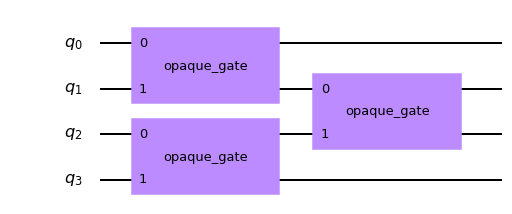

In [3]:
from qiskit.circuit import Gate
#1. Opaque Gates
#Gate constructor need an integer number of qubits (num_qubits) and 
#an integer number of bits (num_cbits) 
#these two define the quantum and classical width of the gate
my_gate = Gate(name='opaque_gate', num_qubits=2, params=[])

#We create a register of 5 qubits
qr = QuantumRegister(4, 'q')
#Then we create blank quantum circuit
circ = QuantumCircuit(qr)
#Now we append gates using append(instruction, qargs, cargs) method of QuantumCircuit 
#It takes Instruction instance and 
#attaches it to the circuit at the specified qargs and cargs.
circ.append(my_gate, [qr[0], qr[1]])
circ.append(my_gate, [qr[2], qr[3]])
circ.append(my_gate, [qr[1], qr[2]])
circ.draw(output='mpl')

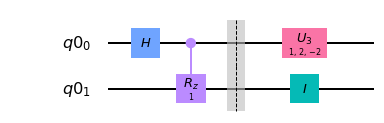

In [4]:
#2. Composite Gates
#Composite gates and complex circuit components are constructed and managed 
#as independent QuantumCircuits 

# Build a sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circuit')
#Add a Hadamard gate to 0th qubit
sub_circ.h(sub_q[0])
#Add a Pauli-Z gate to 0th and 1st qubit
sub_circ.crz(1, sub_q[0], sub_q[1])
#Add a barrier
sub_circ.barrier()
#Add an identity gate
sub_circ.i(sub_q[1])
#Add a U3 gate
sub_circ.u3(1, 2, -2, sub_q[0])

sub_circ.draw(output='mpl')

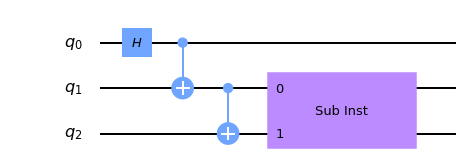

In [7]:
#through the to_instruction method, 
#the individual gate outputs are converted to Instructions to be appended 
#to a target circuit at a given location.
# Convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()
sub_inst.label = "Sub Inst"    # Add a label to avoid the bug

#Now we construct our main circuit of 3 qubits
qr1 = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr1)
#We add a Hadamard
circ.h(qr1[0])
#We add two Pauli-X gates
circ.cx(qr1[0], qr1[1])
circ.cx(qr1[1], qr1[2])
#Now we add our sub_circuit, in the form of instruction that we had created earlier
circ.append(sub_inst, [qr1[1], qr1[2]])

circ.draw('mpl')

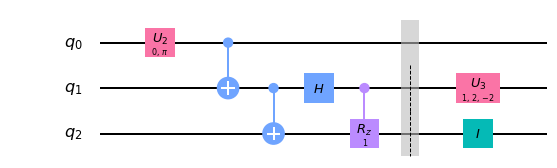

In [15]:
#Circuits are not immediately decomposed upon conversion to_instruction. 
#So that circuit design is possible maintaining higher levels of abstraction. 

#When desired (or before compilation)
#sub-circuits will be decomposed via the decompose method.
decomposed_circ = circ.decompose() # Doesn't modify original
decomposed_circ.draw(output='mpl')
#Decomposed quantum circuit with 7 gates.

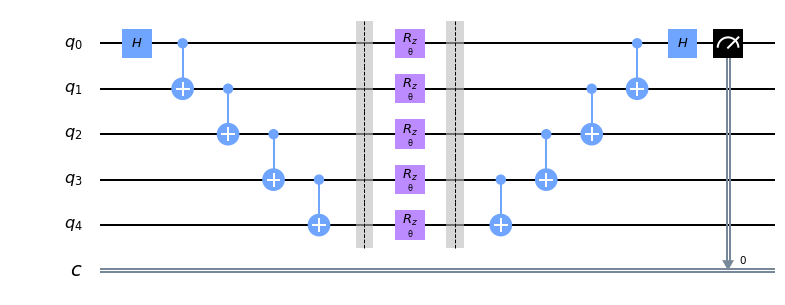

In [16]:
#Parameterized Gates
#Parameterization is a common feature of many quantum algorithms, 
#as well as a standard building block for constructing libraries of standard gates and 
#sub-circuits.
#Parameterized gates are used to construct a series of experiments 
#by varying the angle of a global Rz rotation over a set of entangled qubits.
from qiskit.circuit import Parameter

#The Parameter class is used to specify a place-holder for a numeric parameter
theta = Parameter('θ')
n = 5
#Create a blank QC of 5 qubits
qc = QuantumCircuit(5, 1)
#Add a Hadamard Gate at q0
qc.h(0)
#Add CX gates to the all the qubits linearly, like 0-1,1-2,2-3 etc.
for i in range(n-1):
    qc.cx(i, i+1)

#Add a barrier    
qc.barrier()
#Add a Rotation Gate using the parameter
qc.rz(theta, range(5))
#Add another barrier
qc.barrier()

#Add CX gates to the all the qubits linearly, 
#in reverse order - like 5-4,4-3 etc.
for i in reversed(range(n-1)):
    qc.cx(i, i+1)
#Add a Hadamard Gate
qc.h(0)

#Now add a measurement unit to q0
qc.measure(0, 0)

qc.draw(output='mpl')
#Quantum circuit with parameterized z-rotation gates.

In [17]:
#Inspect the circuit’s parameters property.
print(qc.parameters)

{Parameter(θ)}


In [19]:
#Combining Parameterized Circuits
#Parameterized circuits can be composed like standard QuantumCircuits. 

#Generally, when composing two parameterized circuits, 
#the resulting circuit will be parameterized by the union of the parameters of the input circuits.

#However, parameter names must be unique within a given circuit. 

#When attempting to add a parameter whose name is already present in the target circuit:
#a) if the source and target share the same Parameter instance, 
#the parameters will be assumed to be the same and combined
#b) if the source and target have different Parameter instances, an error will be raised
phi = Parameter('phi')

sub_circ1 = QuantumCircuit(2, name='sc_1')
sub_circ1.rz(phi, 0)
sub_circ1.rx(phi, 1)

sub_circ2 = QuantumCircuit(2, name='sc_2')
sub_circ2.rx(phi, 0)
sub_circ2.rz(phi, 1)

qc = QuantumCircuit(4)
qr = qc.qregs[0]

qc.append(sub_circ1.to_instruction(), [qr[0], qr[1]])
qc.append(sub_circ2.to_instruction(), [qr[0], qr[1]])

qc.append(sub_circ2.to_instruction(), [qr[2], qr[3]])

#qc.draw(output='mpl')
qc.draw()
# The following raises an error: "QiskitError: 'Name conflict on adding parameter: phi'"
# phi2 = Parameter('phi')
# qc.u3(0.1, phi2, 0.3, 0)

#Quantum circuit with 3 custom parameterized gates.

┌────────────┐┌────────────┐
q_0: ┤0           ├┤0           ├
     │  sc_1(phi) ││  sc_2(phi) │
q_1: ┤1           ├┤1           ├
     ├────────────┤└────────────┘
q_2: ┤0           ├──────────────
     │  sc_2(phi) │              
q_3: ┤1           ├──────────────
     └────────────┘

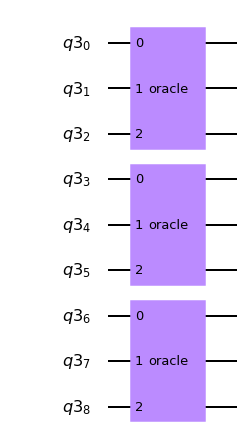

In [20]:
#To insert a sub-circuit under a different parameterization, 
#the to_instruction method accepts an optional argument (parameter_map) which, 
#when present, will generate instructions with the source parameter replaced by a new parameter.
p = Parameter('p')
qc = QuantumCircuit(3, name='oracle')
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
gamma = Parameter('gamma')

qr = QuantumRegister(9)
larger_qc = QuantumCircuit(qr)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: gamma}), qr[6:9])
larger_qc.draw(output='mpl')
#Quantum circuit with 3 custom parameterized 3-qubit gates, each on their own triple of qubits.

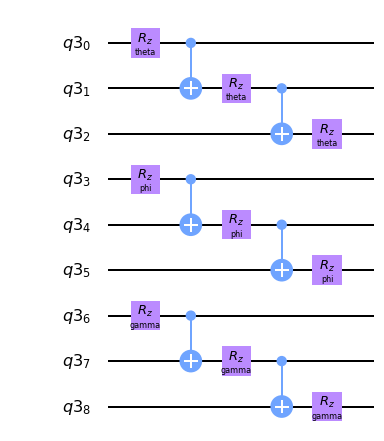

In [21]:
larger_qc.decompose().draw(output='mpl')
#Quantum circuit with the gates in the diagram above, decomposed.

In [22]:
#Binding Parameters to Values
#All circuit parameters must be bound before sending the circuit to a backend. 
#This can be done in one of two ways:
#1. The bind_parameters method accepts a dictionary mapping Parameters to values, 
#and returns a new circuit with each parameter replaced by its corresponding value. 
#Partial binding is supported, in which case the returned circuit will be parameterized 
#by any Parameters which were not mapped to a value.
import numpy as np
theta_range = np.linspace(0, 2 * np.pi, 128)
print(theta_range)
value_dict = ({'theta': theta_val}) for theta_val in theta_range


SyntaxError: invalid syntax (<ipython-input-22-a7de9dddc878>, line 11)

In [14]:

    set()

    Quantum circuit with 5 z-rotation gates each rotating by 2 pi.

    qiskit.execute accepts a parameter_binds keyword argument which, when specified as a list of dictionaries mapping Parameters to values, will bind and execute a circuit on the backend for every mapping dictionary in the list.

    from qiskit import BasicAer, execute

    job = execute(qc,
                backend=BasicAer.get_backend('qasm_simulator'),
                parameter_binds=[{theta: theta_val}
                  for theta_val in theta_range])

    # Note: Bind labels aren't preserved in executions.
    counts = [job.result().get_counts(i)
      for i in range(len(job.result().results))]

In the example circuit, we apply a global    
rotation on 5-qubit entangled state and so expect to see oscillation in qubit-0 at  

.

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(theta_range,
        list(map(lambda c: c.get('0', 0), counts)),
        '.-',
        label='0')
ax.plot(theta_range,
        list(map(lambda c: c.get('1', 0), counts)),
        '.-',
        label='1')

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(
    ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'],
    fontsize=14)
ax.set_xlabel('θ')
ax.legend()
plt.show()

Two oscillating curves of the observed counts of 0 and 1 states. The two curves are off by a relative phase of pi / 5.
Reducing Compilation Time¶

Compiling over a parameterized circuit prior to binding can, in some cases, significantly reduce compilation time as compared to compiling over a set of bound circuits.

import time
from itertools import combinations
from qiskit.compiler import transpile, assemble
from qiskit.test.mock import FakeTokyo

start = time.time()
qcs = []

theta_range = np.linspace(0, 2*np.pi, 32)

for n in theta_range:
    qc = QuantumCircuit(5)

    for k in range(8):
        for i,j in combinations(range(5), 2):
            qc.cx(i,j)
        qc.rz(n, range(5))
        for i,j in combinations(range(5), 2):
            qc.cx(i,j)

    qcs.append(qc)

compiled_circuits = transpile(qcs, backend=FakeTokyo())
qobj = assemble(compiled_circuits, backend=FakeTokyo())

end = time.time()
print('Time compiling over set of bound circuits: ', end-start)

Time compiling over set of bound circuits:  75.6394031047821

start = time.time()
qc = QuantumCircuit(5)
theta = Parameter('theta')

for k in range(8):
    for i,j in combinations(range(5), 2):
        qc.cx(i,j)
    qc.rz(theta, range(5))
    for i,j in combinations(range(5), 2):
        qc.cx(i,j)

transpiled_qc = transpile(qc, backend=FakeTokyo())
qobj = assemble([transpiled_qc.bind_parameters({theta: n})
                 for n in theta_range], backend=FakeTokyo())
end = time.time()
print('Time compiling over parameterized circuit, then binding: ', end-start)

Time compiling over parameterized circuit, then binding:  8.703618049621582



{'1': 1024}